# Monthly Playlist Analysis

> Todo
> - `sp.playlist` only returns first 100 tracks. Not sure there's a way to offset the spotipy

## 0.0 Imports & Setup

### 0.1 Imports

In [1]:
import os
import spotipy
from spotipy.oauth2 import SpotifyOAuth
import numpy as np
import pandas as pd
import datetime
import time
from matplotlib import pyplot as plt

### 0.2 Setup

In [ ]:
spotipy.Spotify

In [2]:
# Global variables

# get API client capable of reading my private playlists
sp = spotipy.Spotify(
    auth_manager=SpotifyOAuth(
            scope="playlist-read-private", 
            client_id=os.getenv('SPOTIPY_CLIENT_ID'),
            client_secret=os.getenv('SPOTIPY_CLIENT_SECRET'),
            redirect_uri=os.getenv('SPOTIPY_REDIRECT_URI')
    ),
    backoff_factor = 0.5  # may need tweaking to balance between rate limit and 
)

year_styles = {'2018':'2018',
               '2019':'2019',
               '2020':'2020',
               '2021':'2021',
               '2022':' 22',
               '2023':' 23',
               '2024':'-24',
               '2025':'2025'}

In [ ]:
sp.playlist('data/playlists_2025-05-31.csv')

In [ ]:
class MonthlyPlaylistHandler:
    '''
    Handler for monthly playlist data. Contains a spotipy Spotify instance,
    handling authentication.
    '''

    # style of each monthly playlist title in each year
    year_styles = {'2018':'2018',
                   '2019':'2019',
                   '2020':'2020',
                   '2021':'2021',
                   '2022':' 22',
                   '2023':' 23',
                   '2024':'-24',
                   '2025':'2025'}
    
    data_dir = 'data'
    
    def __init__(self, spotify_client:spotipy.Spotify = None):
        '''
        Create a new instance of the handler.

        Parameters
        ----------
        spotify_client : spotipy.Spotify, optional
            The spotify client handler from spotipy. Should be instantiated with
            a SpotifyOAuth manager as the auth_manager
        '''
        if spotify_client is None:
            spotify_client = self._new_sp_client()
        self.sp_client = spotify_client

    def _new_sp_client(self, client_id:str = None, client_secret:str = None, redirect_uri:str = None,
                       backoff_factor:float = 0.5, **kwargs):
        '''
        Create a new instance of spotipy.Spotify(), optionally providing alternative
        authentication credentials.

        Parameters
        ----------
        client_id : str, optional
            client_id for Spotify API OAuth authentication. If None, the environment
            variable 'SPOTIPY_CLIENT_ID' will be used.
        client_secret : str, optional
            client_secret for Spotify API OAuth authentication. If None, the environment
            variable 'SPOTIPY_CLIENT_SECRET' will be used.
        redirect_uri : str, optional
            redirect_uri for Spotify API OAuth authentication. If None, the environment
            variable 'SPOTIPY_REDIRECT_URI' will be used.
        backoff_factor : float
            A factor to apply between API call attempts after the second try. 
            See https://urllib3.readthedocs.io/en/latest/reference/urllib3.util.html.
        **kwargs
            Optional keyword arguments to pass to spotipy.Spotify.
        '''

        if client_id is None:
            client_id = os.getenv('SPOTIPY_CLIENT_ID')
        if client_secret is None:
            client_secret = os.getenv('SPOTIPY_CLIENT_SECRET')
        if redirect_uri is None:
            redirect_uri = os.getenv('SPOTIPY_REDIRECT_URI')
        
        return spotipy.Spotify(
            auth_manager=spotipy.SpotifyOAuth(
                scope="playlist-read-private", 
                client_id=client_id,
                client_secret=client_secret,
                redirect_uri=redirect_uri
            ),
            backoff_factor=backoff_factor,
            **kwargs
        )
        
    def get_monthly_playlists(self, to_csv:bool = True) -> pd.DataFrame:
        '''
        Get a dataframe containing monthly playlists metadata.

        Parameters
        ----------
        to_csv : bool
            If True, will save the resulting pd.DataFrame as a CSV in the data directory.
            Filenames are in the format 'playlists_YYYY-MM-DD.csv'. Note that this means any
            other files created on this day will be overwritten.
        '''

        got_all_pls = False
        offset = 0
        df = pd.DataFrame(columns=['collaborative', 'description', 'external_urls', 'href', 'id', 'images',
                                   'name', 'owner', 'primary_color', 'public', 'snapshot_id', 'tracks',
                                   'type', 'uri'])
        while not got_all_pls:
            playlists = self.sp_client.current_user_playlists(offset = offset)
            df = pd.concat([df, pd.DataFrame(playlists['items'])], ignore_index = True)
            
            if len(playlists['items']) < 50:
                got_all_pls = True
            offset += 50

        ind = df['name'].astype(bool)  # series containing indexes of all monthly playlists
        ind[:] = False  # ensure we start with all False

        for year_style in year_styles.values():
            ind = ind | df['name'].str.contains(year_style)
        df = df.loc[ind]  # apply index

        # only keep useful columns
        df = df[['id', 'name', 'description', 'href', 'images', 'snapshot_id']].set_index('id')

        # save if requested, and return
        if to_csv:
            df.to_csv(f'data/playlists_{str(datetime.datetime.now().date())}.csv')
        return df

    @property
    def latest_playlists_file(self):
        # get the most recent date by extracting the date part of each playlist_DATE.csv file.
        # then convert to datetime, and get the most recent (max)
        most_recent_date = pd.to_datetime([file.replace('playlists_','').replace('.csv','') for file in os.listdir(self.data_dir) if 'playlists' in file]).max()

        return f'playlists_{str(most_recent_date.date())}.csv'

    def read_monthly_playlists(self, date = 'latest'):
        '''
        Read a saved DataFrame of monthly playlists.

        Parameters
        ----------
        date : str or datetime.date
            The date the data was collected. Defaults to 'latest', which retrieves the most recent
            file. If the date is specified as a string, it should be given in the form YYYY-MM-DD.
        
        Returns
        -------
        pandas.DataFrame
        '''
        if date == 'latest':
            file = self.latest_playlists_file
        elif isinstance(date, datetime.date):
            file = f'playlists_{str(date.date())}.csv'
        elif isinstance(date, str):
            file = f'playlists_{date}.csv'
        else:
            raise ValueError(f'Unexpected type "{type(date)}" for date input encountered. Try entering date as either a string (YYYY-MM-DD) or datetime.date.')
        
        return pd.read_csv(
            os.path.join(self.data_dir, file), 
            index_col = 0
        )



In [48]:
'playlists_2025-05-31.csv'.replace('playlists_','').replace('.csv','')

'2025-05-31'

In [66]:
isinstance(datetime.datetime.now().date(), datetime.date)

True

In [ ]:
datetime.datetime('2025-05-31')

TypeError: descriptor 'date' for 'datetime.datetime' objects doesn't apply to a 'str' object

In [61]:
most_recent_date = pd.to_datetime([file.replace('playlists_','').replace('.csv','') for file in os.listdir('data') if 'playlists' in file]).max()

os.path.join('data', 'playlists_'+str(most_recent_date.date())+'.csv')

'data/playlists_2025-05-31.csv'

## 1.0 Data Querying & Cleaning

In [42]:
df_pl_mth[['id', 'name', 'description', 'href', 'images', 'snapshot_id']].set_index('id')

,name,description,href,images,snapshot_id
id,,,,,
1dAKocsMZ2g4AqkY9nV906,June 2025,it seems perhaps they will,https://api.spotify.com/v1/playlists/1dAKocsMZ...,NaN,AAAABO9a2o0gvmgiFkcsjCSvfEerYJp5
66MNjc3azuCiTlhQe6zHqq,May 2025,complete unabridged boys night,https://api.spotify.com/v1/playlists/66MNjc3az...,"[{'height': None, 'url': 'https://image-cdn-ak...",AAAAOq0HobHDBHF80VoXgOVLKhBCExWe
1YHt2tcyv5xR5m2KX0rA9t,April 2025,b.abka,https://api.spotify.com/v1/playlists/1YHt2tcyv...,"[{'height': None, 'url': 'https://image-cdn-ak...",AAAAH8DWI2H7jRk8InDsNHjLS9YNsySv
393eD1ePHqyMRaEREcBow8,March 2025,unintentional,https://api.spotify.com/v1/playlists/393eD1ePH...,"[{'height': None, 'url': 'https://image-cdn-ak...",AAAAPL7d377RlSsMMCzLFNmT4wuTJ86z
1Vc3qFg0aLYW74jKls7KJr,February 2025,needlessly impressive,https://api.spotify.com/v1/playlists/1Vc3qFg0a...,"[{'height': None, 'url': 'https://image-cdn-ak...",AAAAWDjRI+qO1uUHINQWiH1kLCnzhxNm
...,...,...,...,...,...
2FPpIykbTksWiEpQOoo0IX,may 2018,pv = n r t,https://api.spotify.com/v1/playlists/2FPpIykbT...,"[{'height': None, 'url': 'https://image-cdn-ak...",AAAAIyn+OulAx6smCpUkxFymtLsbo/dr
5TKjuQprN0KrP6JODUDgv0,april 2018,shacking up,https://api.spotify.com/v1/playlists/5TKjuQprN...,"[{'height': None, 'url': 'https://image-cdn-ak...",AAAANFySg4bUYJ+jHFH83WH+SBa6GSDn
2KrIMSlTHz7UTUT8y1CjCP,march 2018,beats from the east,https://api.spotify.com/v1/playlists/2KrIMSlTH...,"[{'height': None, 'url': 'https://image-cdn-ak...",AAAAMYCwh3qoyRCIBN79A0Zy/0ry3EVB


In [5]:
df_pl_mth = pd.read_csv('data/playlists_2025-05-31.csv', index_col=0)

In [30]:
id = '7ewWgiTUuOjSTfKhD0y1ve'
r = sp.playlist_items(id,offset=100)
r2 = sp.playlist(id)

In [31]:
len(r['items'])

27

In [28]:
df_pl_mth['tracks'].apply(lambda x: eval(x)['total']).max()

151

In [23]:
df_pl_mth[df_pl_mth['tracks'].apply(lambda x: eval(x)['total']) > 100]

,collaborative,description,external_urls,href,id,images,name,owner,primary_color,public,snapshot_id,tracks,type,uri
20,False,abdominal snowman,{'spotify': 'https://open.spotify.com/playlist...,https://api.spotify.com/v1/playlists/7ewWgiTUu...,7ewWgiTUuOjSTfKhD0y1ve,"[{'height': None, 'url': 'https://image-cdn-ak...",01-24,"{'display_name': 'Hugo Neely', 'external_urls'...",NaN,True,AAAAkEQZ+Q4ZfrVdnudPlAdGcWix2+Ty,{'href': 'https://api.spotify.com/v1/playlists...,playlist,spotify:playlist:7ewWgiTUuOjSTfKhD0y1ve
30,False,drums on toast,{'spotify': 'https://open.spotify.com/playlist...,https://api.spotify.com/v1/playlists/7EK6zHUea...,7EK6zHUea4x1DZctXCPqJR,"[{'height': None, 'url': 'https://image-cdn-ak...",11 23,"{'display_name': 'Hugo Neely', 'external_urls'...",NaN,True,AAAAgPFGT7eqPDD59jn4Opbhcb1BoAtk,{'href': 'https://api.spotify.com/v1/playlists...,playlist,spotify:playlist:7EK6zHUea4x1DZctXCPqJR
38,False,having your cake and eating it anyway (yum yum...,{'spotify': 'https://open.spotify.com/playlist...,https://api.spotify.com/v1/playlists/79CXJhRxq...,79CXJhRxqMLshmJZwl9uqy,"[{'height': None, 'url': 'https://image-cdn-ak...",03 23,"{'display_name': 'Hugo Neely', 'external_urls'...",NaN,True,AAAAhfUwPC3wWBYT461rV2hnIvj+K+P6,{'href': 'https://api.spotify.com/v1/playlists...,playlist,spotify:playlist:79CXJhRxqMLshmJZwl9uqy
40,False,"look mum, no hands!",{'spotify': 'https://open.spotify.com/playlist...,https://api.spotify.com/v1/playlists/44nFuJqeX...,44nFuJqeXWOb9xD3LCFp2c,"[{'height': None, 'url': 'https://image-cdn-ak...",01 23,"{'display_name': 'Hugo Neely', 'external_urls'...",NaN,True,AAAAmP5DH/KuNEMLWEkutj6yIGfGCHd4,{'href': 'https://api.spotify.com/v1/playlists...,playlist,spotify:playlist:44nFuJqeXWOb9xD3LCFp2c
98,False,swimming downstream,{'spotify': 'https://open.spotify.com/playlist...,https://api.spotify.com/v1/playlists/4k7RTxBhN...,4k7RTxBhNonNd5hjHQ3meO,"[{'height': None, 'url': 'https://image-cdn-ak...",dec 22,"{'display_name': 'Hugo Neely', 'external_urls'...",NaN,True,AAAAiYaCkiLchlbcoOevQOM1hT+6uaKq,{'href': 'https://api.spotify.com/v1/playlists...,playlist,spotify:playlist:4k7RTxBhNonNd5hjHQ3meO
100,False,chutzpah!!,{'spotify': 'https://open.spotify.com/playlist...,https://api.spotify.com/v1/playlists/2YZMSqt5Q...,2YZMSqt5QG7cltBEUzYNzO,"[{'height': None, 'url': 'https://image-cdn-ak...",oct 22,"{'display_name': 'Hugo Neely', 'external_urls'...",NaN,True,AAAAeiP47qo3oA8xSxy1IjAMxOh3fby0,{'href': 'https://api.spotify.com/v1/playlists...,playlist,spotify:playlist:2YZMSqt5QG7cltBEUzYNzO
103,False,absolutley clueless,{'spotify': 'https://open.spotify.com/playlist...,https://api.spotify.com/v1/playlists/1DqofdJ6c...,1DqofdJ6cFi58tiXtuNQ68,"[{'height': None, 'url': 'https://image-cdn-ak...",jul 22,"{'display_name': 'Hugo Neely', 'external_urls'...",NaN,True,AAAAo0pXFMbUVRpkqqZhRcIBjj9eGNjb,{'href': 'https://api.spotify.com/v1/playlists...,playlist,spotify:playlist:1DqofdJ6cFi58tiXtuNQ68
108,False,"the answer, my friend, is floppin in the wind",{'spotify': 'https://open.spotify.com/playlist...,https://api.spotify.com/v1/playlists/50k1988Ey...,50k1988Ey779tICEI2Likg,"[{'height': None, 'url': 'https://image-cdn-ak...",feb 22,"{'display_name': 'Hugo Neely', 'external_urls'...",NaN,True,AAAAq3UM4jnQIFOVnlfi6JyG7JjTHVii,{'href': 'https://api.spotify.com/v1/playlists...,playlist,spotify:playlist:50k1988Ey779tICEI2Likg
110,False,uh oh (uh oh),{'spotify': 'https://open.spotify.com/playlist...,https://api.spotify.com/v1/playlists/5ksAwFvII...,5ksAwFvIIfPpvDnOss6lGH,"[{'height': None, 'url': 'https://image-cdn-ak...",december 2021,"{'display_name': 'Hugo Neely', 'external_urls'...",NaN,True,AAAAjWEKdHTZIilcyOGIWAvBQ8RWKbrA,{'href': 'https://api.spotify.com/v1/playlists...,playlist,spotify:playlist:5ksAwFvIIfPpvDnOss6lGH
117,False,aaaahhhhhhhh,{'spotify': 'https://open.spotify.com/playlist...,https://api.spotify.com/v1/playlists/0h9sZPt0y...,0h9sZPt0yVyeiP38x8hidw,"[{'height': None, 'url': 'https://image-cdn-ak...",may 2

In [4]:
df_pl_mth = get_monthly_playlists()
df_pl_mth

,collaborative,description,external_urls,href,id,images,name,owner,primary_color,public,snapshot_id,tracks,type,uri
3,False,it seems perhaps they will,{'spotify': 'https://open.spotify.com/playlist...,https://api.spotify.com/v1/playlists/1dAKocsMZ...,1dAKocsMZ2g4AqkY9nV906,None,June 2025,"{'display_name': 'Hugo Neely', 'external_urls'...",None,True,AAAABO9a2o0gvmgiFkcsjCSvfEerYJp5,{'href': 'https://api.spotify.com/v1/playlists...,playlist,spotify:playlist:1dAKocsMZ2g4AqkY9nV906
4,False,complete unabridged boys night,{'spotify': 'https://open.spotify.com/playlist...,https://api.spotify.com/v1/playlists/66MNjc3az...,66MNjc3azuCiTlhQe6zHqq,"[{'height': None, 'url': 'https://image-cdn-ak...",May 2025,"{'display_name': 'Hugo Neely', 'external_urls'...",None,True,AAAAOq0HobHDBHF80VoXgOVLKhBCExWe,{'href': 'https://api.spotify.com/v1/playlists...,playlist,spotify:playlist:66MNjc3azuCiTlhQe6zHqq
5,False,b.abka,{'spotify': 'https://open.spotify.com/playlist...,https://api.spotify.com/v1/playlists/1YHt2tcyv...,1YHt2tcyv5xR5m2KX0rA9t,"[{'height': None, 'url': 'https://image-cdn-ak...",April 2025,"{'display_name': 'Hugo Neely', 'external_urls'...",None,True,AAAAH8DWI2H7jRk8InDsNHjLS9YNsySv,{'href': 'https://api.spotify.com/v1/playlists...,playlist,spotify:playlist:1YHt2tcyv5xR5m2KX0rA9t
6,False,unintentional,{'spotify': 'https://open.spotify.com/playlist...,https://api.spotify.com/v1/playlists/393eD1ePH...,393eD1ePHqyMRaEREcBow8,"[{'height': None, 'url': 'https://image-cdn-ak...",March 2025,"{'display_name': 'Hugo Neely', 'external_urls'...",None,True,AAAAPL7d377RlSsMMCzLFNmT4wuTJ86z,{'href': 'https://api.spotify.com/v1/playlists...,playlist,spotify:playlist:393eD1ePHqyMRaEREcBow8
7,False,needlessly impressive,{'spotify': 'https://open.spotify.com/playlist...,https://api.spotify.com/v1/playlists/1Vc3qFg0a...,1Vc3qFg0aLYW74jKls7KJr,"[{'height': None, 'url': 'https://image-cdn-ak...",February 2025,"{'display_name': 'Hugo Neely', 'external_urls'...",None,True,AAAAWDjRI+qO1uUHINQWiH1kLCnzhxNm,{'href': 'https://api.spotify.com/v1/playlists...,playlist,spotify:playlist:1Vc3qFg0aLYW74jKls7KJr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,False,pv = n r t,{'spotify': 'https://open.spotify.com/playlist...,https://api.spotify.com/v1/playlists/2FPpIykbT...,2FPpIykbTksWiEpQOoo0IX,"[{'height': None, 'url': 'https://image-cdn-ak...",may 2018,"{'display_name': 'Hugo Neely', 'external_urls'...",None,True,AAAAIyn+OulAx6smCpUkxFymtLsbo/dr,{'href': 'https://api.spotify.com/v1/playlists...,playlist,spotify:playlist:2FPpIykbTksWiEpQOoo0IX
154,False,shacking up,{'spotify': 'https://open.spotify.com/playlist...,https://api.spotify.com/v1/playlists/5TKjuQprN...,5TKjuQprN0KrP6JODUDgv0,"[{'height': None, 'url': 'https://image-cdn-ak...",april 2018,"{'display_name': 'Hugo Neely', 'external_urls'...",None,True,AAAANFySg4bUYJ+jHFH83WH+SBa6GSDn,{'href': 'https://api.spotify.com/v1/playlists...,playlist,spotify:playlist:5TKjuQprN0KrP6JODUDgv0
155,False,beats from the east,{'spotify': 'https://open.spotify.com/playlist...,https://api.spotify.com/v1/playlists/2KrIMSlTH...,2KrIMSlTHz7UTUT8y1CjCP,"[{'height': None, 'url': 'https://image-cdn-ak...",march 2018,"{'display_name': 'Hugo Neely', 'external_urls'...",None,True,AAAAMYCwh3qoyRCIBN79A0Zy/0ry3EVB,{'href': 'https://api.spotify.com/v1/playlists...,playlist,spotify:playlist:2KrIMSlTHz7UTUT8y1CjCP
156,False,reeperbahngers,{'spotify': 'https://open.spotify.com/playlist...,https://api.spotify.com/v1/playlists/7JsfpKz6h...,7JsfpKz6hajnT1PpUUPHrb,"[{'height': None, 'url': 'https://image-cdn-ak...",february 2018,"{'display_name': 'Hugo Neely', 'external_urls'...",None,True,AAAAMK5uVnVyrxlmNxU/WOMmjuLrU1uF,{'href': 'https://api.spotify.com/v1/playlists...,playlist,spotify:playlist:7JsfpKz6hajnT1PpUUPHrb


In [ ]:
track_names = []
track_artists = []
track_date_added = []
playlist_names = []
track_index = []  # 1-indexed position in the playlist
track_artists_index = []  # 1-indexed order of artist on the track
track_album = []
track_release_date = []
track_release_date_precision = []
track_duration = []
track_popularities = []  # note this will change over time, as it depends on number of listens and how recent those listens are
track_external_ids = []  # probably not useful, but could be
track_spid = []
track_artist_genres = []
track_artist_popularity = []

# get track info for all monthly playlists
for id in df_pl_mth['id']:
    # get playlist
    pl_mth = sp.playlist(id)
    time.sleep(20)  # shhh little spotify api client. do not complain. it will all be ok. just rest.

    # iterate through tracks
    for track_i, track in enumerate(pl_mth['tracks']['items']):

        # iterate through each track's artists (can have multiple)
        for artist_i, artist in enumerate(track['track']['artists']):
            # append all data to lists:
            # playlist info
            playlist_names.append(pl_mth['name'])
            track_index.append(track_i + 1)

            # track name, album, artists
            track_date_added.append(track['added_at'])
            track_names.append(track['track']['name'])
            track_artists.append(artist['name'])
            track_artists_index.append(artist_i + 1)  # 1-indexed, not 0
            track_album.append(track['track']['album']['name'])
            

            artist_expanded = sp.artist(artist['id'])
            time.sleep(5)  # little nap

            track_artist_genres.append(artist_expanded['genres'])
            track_artist_popularity.append(artist_expanded['popularity'])

            # track info
            track_release_date.append(track['track']['album']['release_date'])
            track_release_date_precision.append(track['track']['album']['release_date_precision'])
            track_popularities.append(track['track']['popularity'])
            track_duration.append(track['track']['duration_ms'])
            track_external_ids.append(track['track']['external_ids'])
            track_spid.append(track['track']['id'])

KeyboardInterrupt: 

In [ ]:
if track['track']['artists']['id'] not in artist_data:
    next_artist_call.append(track['track']['artists']['id'])

[{'external_urls': {'spotify': 'https://open.spotify.com/artist/0WwSkZ7LtFUFjGjMZBMt6T'},
  'href': 'https://api.spotify.com/v1/artists/0WwSkZ7LtFUFjGjMZBMt6T',
  'id': '0WwSkZ7LtFUFjGjMZBMt6T',
  'name': 'Dire Straits',
  'type': 'artist',
  'uri': 'spotify:artist:0WwSkZ7LtFUFjGjMZBMt6T'}]

In [19]:
a = 15
len(df_pl_mth) * a/60

22.5

In [ ]:
track_names = []
track_artists = []
track_date_added = []
playlist_names = []
track_index = []  # 1-indexed position in the playlist
track_artists_index = []  # 1-indexed order of artist on the track
track_album = []
track_release_date = []
track_release_date_precision = []
track_duration = []
track_popularities = []  # note this will change over time, as it depends on number of listens and how recent those listens are
track_external_ids = []  # probably not useful, but could be
track_spid = []
track_artist_genres = []
track_artist_popularity = []

# object to store artist id. will be checked to prevent duplicate API calls
artist_data = {}


# get track info for all monthly playlists
for id in df_pl_mth['id']:
    # get playlist
    pl_mth = sp.playlist(id)
    time.sleep(30)  # shhh little spotify api client. do not complain. it will all be ok. just rest.

    for track_i, track in enumerate(pl_mth['tracks']['items']):

        artist_ids = [x['id'] for x in track['track']['artists']]
        track_artists = sp.artists(artist_ids)
        time.sleep(10)

        # iterate through each track's artists (can have multiple)
        for artist_i, artist in enumerate(track['track']['artists']):

            # append all data we can get from the playlist call to lists:
            if True:
                # playlist info
                playlist_names.append(pl_mth['name'])
                track_index.append(track_i + 1)

                # track name, album, artists
                track_date_added.append(track['added_at'])
                track_names.append(track['track']['name'])
                track_artists.append(artist['name'])
                track_artists_index.append(artist_i + 1)
                track_album.append(track['track']['album']['name'])

                # track info
                track_release_date.append(track['track']['album']['release_date'])
                track_release_date_precision.append(track['track']['album']['release_date_precision'])
                track_popularities.append(track['track']['popularity'])
                track_duration.append(track['track']['duration_ms'])
                track_external_ids.append(track['track']['external_ids'])
                track_spid.append(track['track']['id'])

            # add an empty entry to the artist db
            if artist['id'] not in artist_data:
                artist_data[artist['id']:{}]


artist_ids_batch = []
for id in artist_data:
    
    while len(artist_ids_batch) < 50:
        artist_ids_batch.append(id)
    
    artists = sp.artists(artist_ids_batch)
    for artist in artists:
        artist_data[id]
        track_artist_genres.append(artist_expanded['genres'])
        track_artist_popularity.append(artist_expanded['popularity'])
    artist_ids_batch = []
        


In [ ]:

# get track info for all monthly playlists
for id in df_pl_mth['id']:  # 90
    # get playlist
    pl_mth = sp.playlist(id)
    time.sleep(30)  # shhh little spotify api client. do not complain. it will all be ok. just rest.

    for track_i, track in enumerate(pl_mth['tracks']['items']):  # up to like 150 max. usually below 100

        track_artists = sp.artists(artist_ids)
        time.sleep(10)
        ...

for id in artist_data:  # total number of artists in dataset. lots, though will be less than total number of tracks
    
    while len(artist_ids_batch) < 50:
        artist_ids_batch.append(id)
    
    artists = sp.artists(artist_ids_batch)  # make n_artists/50 calls
    ...
        


In [44]:
api_res

,Unnamed: 0,playlist_name,track_index,added_date,track_name,track_artist,track_artist_index,track_album,track_release_date,track_release_date_precision,track_popularity,track_duration_ms,track_external_ids,track_spotify_id,isrc_country
0,0,March 2025,1,2025-03-01 13:47:18+00:00,Down To The Waterline,Dire Straits,1,Dire Straits,1978-10-07,day,68,241906,{'isrc': 'GBF087800019'},7fYKKFD0jiSlMDgG9IUs1q,GB
1,1,March 2025,2,2025-03-01 14:40:17+00:00,Lions,Dire Straits,1,Dire Straits,1978-10-07,day,52,303893,{'isrc': 'GBF089601044'},4PgZTLaGAMlKD6FCATr2sz,GB
2,2,March 2025,3,2025-03-02 13:02:22+00:00,Water Of Love,Dire Straits,1,Dire Straits,1978-10-07,day,63,325133,{'isrc': 'GBF087900639'},62JvDbmEtwIU3m4LhiG6Ah,GB
3,3,March 2025,4,2025-03-02 13:09:25+00:00,Six Blade Knife,Dire Straits,1,Dire Straits,1978-10-07,day,70,252000,{'isrc': 'GBF089601039'},2miIOgni3EEut8pvYcxeYn,GB
4,4,March 2025,5,2025-03-02 13:17:20+00:00,Sultans Of Swing,Dire Straits,1,Dire Straits,1978-10-07,day,84,348400,{'isrc': 'GBF089601041'},37Tmv4NnfQeb0ZgUC4fOJj,GB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6223,6223,january 2018,16,2018-01-17 18:15:42+00:00,Two Words,Mos Def,2,The College Dropout (Explicit),2004-01-01,day,0,266213,{'isrc': 'USDJ20300915'},7EzY5a2CMrK5KqCxoOeyIj,US
6224,6224,january 2018,16,2018-01-17 18:15:42+00:00,Two Words,Freeway,3,The College Dropout (Explicit),2004-01-01,day,0,266213,{'isrc': 'USDJ20300915'},7EzY5a2CMrK5KqCxoOeyIj,US
6225,6225,january 2018,16,2018-01-17 18:15:42+00:00,Two Words,The Boys Choir Of Harlem,4,The College Dropout (Explicit),2004-01-01,day,0,266213,{'isrc': 'USDJ20300915'},7EzY5a2CMrK5KqCxoOeyIj,US
6226,6226,january 2018,17,2018-01-31 17:23:09+00:00,"Lie, Cheat, Steal",Run The Jewels,1,Run the Jewels 2,2014-10-24,day,0,208466,{'isrc': 'QM8RL1400018'},3UN6UkL6M0l8vfZS7OffZ6,QM


In [45]:
api_res.groupby('playlist_name').agg({'track_index':'max'})

,track_index
playlist_name,
01 23,100
01-24,100
02 23,61
02-24,83
03 23,100
...,...
sep 22,50
september 2018,10
september 2019,8


In [ ]:
n_playlist_qs = len(df_pl_mth)
n_artist_qs = 

In [42]:
api_res = pd.read_csv('data/api_res_2025-03-28.csv')
print(len(api_res))
print(len(api_res['track_artist'].unique())/50)

6228
37.56


In [33]:
api_res

,Unnamed: 0,playlist_name,track_index,added_date,track_name,track_artist,track_artist_index,track_album,track_release_date,track_release_date_precision,track_popularity,track_duration_ms,track_external_ids,track_spotify_id,isrc_country
0,0,March 2025,1,2025-03-01 13:47:18+00:00,Down To The Waterline,Dire Straits,1,Dire Straits,1978-10-07,day,68,241906,{'isrc': 'GBF087800019'},7fYKKFD0jiSlMDgG9IUs1q,GB
1,1,March 2025,2,2025-03-01 14:40:17+00:00,Lions,Dire Straits,1,Dire Straits,1978-10-07,day,52,303893,{'isrc': 'GBF089601044'},4PgZTLaGAMlKD6FCATr2sz,GB
2,2,March 2025,3,2025-03-02 13:02:22+00:00,Water Of Love,Dire Straits,1,Dire Straits,1978-10-07,day,63,325133,{'isrc': 'GBF087900639'},62JvDbmEtwIU3m4LhiG6Ah,GB
3,3,March 2025,4,2025-03-02 13:09:25+00:00,Six Blade Knife,Dire Straits,1,Dire Straits,1978-10-07,day,70,252000,{'isrc': 'GBF089601039'},2miIOgni3EEut8pvYcxeYn,GB
4,4,March 2025,5,2025-03-02 13:17:20+00:00,Sultans Of Swing,Dire Straits,1,Dire Straits,1978-10-07,day,84,348400,{'isrc': 'GBF089601041'},37Tmv4NnfQeb0ZgUC4fOJj,GB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6223,6223,january 2018,16,2018-01-17 18:15:42+00:00,Two Words,Mos Def,2,The College Dropout (Explicit),2004-01-01,day,0,266213,{'isrc': 'USDJ20300915'},7EzY5a2CMrK5KqCxoOeyIj,US
6224,6224,january 2018,16,2018-01-17 18:15:42+00:00,Two Words,Freeway,3,The College Dropout (Explicit),2004-01-01,day,0,266213,{'isrc': 'USDJ20300915'},7EzY5a2CMrK5KqCxoOeyIj,US
6225,6225,january 2018,16,2018-01-17 18:15:42+00:00,Two Words,The Boys Choir Of Harlem,4,The College Dropout (Explicit),2004-01-01,day,0,266213,{'isrc': 'USDJ20300915'},7EzY5a2CMrK5KqCxoOeyIj,US
6226,6226,january 2018,17,2018-01-31 17:23:09+00:00,"Lie, Cheat, Steal",Run The Jewels,1,Run the Jewels 2,2014-10-24,day,0,208466,{'isrc': 'QM8RL1400018'},3UN6UkL6M0l8vfZS7OffZ6,QM


In [34]:
api_res = pd.read_csv('data/api_res_2025-03-31.csv')
print(len(api_res))
print(np.ceil(len(api_res['artist'].unique())/50))

3193
25.0


In [228]:
df_tracks = pd.DataFrame({
    # playlist info
    'playlist_name': playlist_names, 
    'playlist_index': track_index, 
    'added_date': track_date_added, 

    # names
    'track_name': track_names, 
    'artist': track_artists, 
    'artist_genres':track_artist_genres, 
    'artist_index': track_artists_index, 
    'album': track_album, 

    # info
    'release_date': track_release_date, 
    'release_date_precision': track_release_date_precision, 
    'track_popularity': track_popularities, 
    'artist_popularity': track_artist_popularity, 
    'duration_ms': track_duration, 

    # ids
    'track_external_ids': track_external_ids, 
    'track_spotify_id': track_spid 
})

# tidy data:

# convert to datetime
def standardise_date(date:str):
    # year only
    if len(date) == 4:
        if date == '0000':
            # special case where the track has been removed, and has a null date
            return None
        return date+'-01-01'
    # year + month
    elif len(date) == 7:
        return date+'-01'
    # year + month + date - no need to change
    else:
        return date

df_tracks['added_date'] = pd.to_datetime(df_tracks['added_date'])
df_tracks['release_date'] = pd.to_datetime(df_tracks['release_date'].apply(standardise_date))
df_tracks['playlist_date'] = pd.to_datetime('01-' + df_tracks['added_date'].dt.month.astype(str) + '-' + df_tracks['added_date'].dt.year.astype(str), dayfirst = True).dt.date

# get country code from isrc
def get_isrc_country(dict):
    if 'isrc' in dict.keys():
        return dict['isrc'][:2]
    else:
        return None
df_tracks['isrc_country'] = df_tracks['track_external_ids'].apply(get_isrc_country)

# save to csv and display
df_tracks.to_csv(f'data/api_res_{str(datetime.datetime.now().date())}.csv')
df_tracks

,playlist_name,playlist_index,added_date,track_name,artist,artist_genres,artist_index,album,release_date,release_date_precision,track_popularity,artist_popularity,duration_ms,track_external_ids,track_spotify_id,playlist_date,isrc_country
0,March 2025,1,2025-03-01 13:47:18+00:00,Down To The Waterline,Dire Straits,[classic rock],1,Dire Straits,1978-10-07,day,68,79,241906,{'isrc': 'GBF087800019'},7fYKKFD0jiSlMDgG9IUs1q,2025-03-01,GB
1,March 2025,2,2025-03-01 14:40:17+00:00,Lions,Dire Straits,[classic rock],1,Dire Straits,1978-10-07,day,52,79,303893,{'isrc': 'GBF089601044'},4PgZTLaGAMlKD6FCATr2sz,2025-03-01,GB
2,March 2025,3,2025-03-02 13:02:22+00:00,Water Of Love,Dire Straits,[classic rock],1,Dire Straits,1978-10-07,day,63,79,325133,{'isrc': 'GBF087900639'},62JvDbmEtwIU3m4LhiG6Ah,2025-03-01,GB
3,March 2025,4,2025-03-02 13:09:25+00:00,Six Blade Knife,Dire Straits,[classic rock],1,Dire Straits,1978-10-07,day,70,79,252000,{'isrc': 'GBF089601039'},2miIOgni3EEut8pvYcxeYn,2025-03-01,GB
4,March 2025,5,2025-03-02 13:17:20+00:00,Sultans Of Swing,Dire Straits,[classic rock],1,Dire Straits,1978-10-07,day,84,79,348400,{'isrc': 'GBF089601041'},37Tmv4NnfQeb0ZgUC4fOJj,2025-03-01,GB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3188,jul 22,96,2022-07-17 13:09:06+00:00,The Beat - 2021 Remaster,Elvis Costello & The Attractions,"[new wave, power pop]",1,This Year's Model (2021 Remaster),1978-03-17,day,40,51,228973,{'isrc': 'GBASQ7800025'},1bqlDsBlBPxjK0zuFQcSXq,2022-07-01,GB
3189,jul 22,97,2022-07-17 13:11:17+00:00,Time Was,Canned Heat,"[blues rock, blues, classic blues]",1,Hallelujah,1969-07-08,day,49,56,202253,{'isrc': 'USEM38700073'},1lLQtlPli8kTLJsTrcnRuQ,2022-07-01,US
3190,jul 22,98,2022-07-17 13:15:17+00:00,Eastern Jam,Country Joe & The Fish,"[psychedelic rock, acid rock]",1,I-Feel-Like-I'm-Fixin'-To-Die,1967-01-01,year,26,35,270600,{'isrc': 'USVG28807024'},4mg6TO4GnHzT99YodF0b0W,2022-07-01,US
3191,jul 22,99,2022-07-17 13:19:29+00:00,Gold And Silver,Quicksilver Messenger Service,"[acid rock, psychedelic rock]",1,Quicksilver Messenger Service,1968-01-01,year,33,38,403533,{'isrc': 'USCA28800516'},6qwwAbxSYq9MTEIn0UMFNA,2022-07-01,US


In [16]:
df_tracks = pd.read_csv(f'data/api_res_{str(datetime.datetime.now().date())}.csv')

In [198]:
df_tracks[df_tracks['artist_genres'].apply(lambda x: 'funk rock' in x)].drop_duplicates('artist')

,playlist_name,playlist_index,added_date,track_name,artist,artist_genres,artist_index,album,release_date,release_date_precision,track_popularity,artist_popularity,duration_ms,track_external_ids,track_spotify_id,playlist_date,isrc_country
12,March 2025,13,2025-03-04 18:45:21+00:00,New Beastly,Vulfpeck,[funk rock],1,Clarity of Cal,2025-03-04,day,55,63,251748,{'isrc': 'QMFMF2433745'},1yQNHzLx4VFofmUNHT3FHa,2025-03-01,QM
117,February 2025,39,2025-02-19 14:42:02+00:00,Ain't That Funkin' Kinda Hard on You? (feat. K...,Funkadelic,"[funk rock, funk]",1,Ain't That Funkin' Kinda Hard on You? (We Ain'...,2016-03-09,day,46,52,309723,{'isrc': 'QM2UR1500001'},6SgQIoLn8kpu8J4wfwGWy8,2025-02-01,QM
161,February 2025,72,2025-02-26 14:09:09+00:00,The Force,Lettuce,"[jazz funk, funk rock]",1,Crush,2015-11-06,day,45,46,221933,{'isrc': 'TCACJ1512868'},1da6XFL8cThblY2yvJLEBM,2025-02-01,TC
170,February 2025,80,2025-02-27 19:38:33+00:00,Blue Angels,The Fearless Flyers,"[jazz funk, jazz fusion, funk rock]",1,The Fearless Flyers IV,2024-02-09,day,45,46,270052,{'isrc': 'QZFZ62401446'},3dHdu2fban1DHShcgPed3l,2025-02-01,QZ
221,January 2025,43,2025-01-23 20:00:01+00:00,Otherside,Red Hot Chili Peppers,"[funk rock, alternative rock, rock]",1,Californication (Deluxe Edition),1999-06-08,day,82,84,255373,{'isrc': 'USWB19900693'},64BbK9SFKH2jk86U3dGj2P,2025-01-01,US
1533,09 23,11,2023-09-07 08:46:39+00:00,Love Like Anthrax,Gang Of Four,"[post-punk, new wave, proto-punk, funk rock, p...",1,Entertainment!,1979-09-25,day,29,49,264200,{'isrc': 'GB01A7900022'},0luLrvQxGwkTjCbtGiEaO0,2023-09-01,GB
1978,05 23,20,2023-05-08 12:15:05+00:00,Gemini,Snarky Puppy,"[jazz fusion, jazz funk, jazz, funk rock, nu j...",1,Culcha Vulcha,2016-04-29,day,0,48,315253,{'isrc': 'QZ2EW1600053'},1SQWFRArmVgZYmfJDXLmCT,2023-05-01,QZ


In [199]:
def find_genre(genre = None, df = df_tracks, return_ind = False):
    if isinstance(genre, type(None)):
        ind = df['artist_genres'].apply(lambda x: len(x)) == 0
    else:
        ind = df['artist_genres'].apply(lambda x: genre in x)
    
    if return_ind:
        return ind
    else: 
        return df[ind]

In [ ]:
find_genre() 

,playlist_name,playlist_index,added_date,track_name,artist,artist_genres,artist_index,album,release_date,release_date_precision,track_popularity,artist_popularity,duration_ms,track_external_ids,track_spotify_id,playlist_date,isrc_country
16,March 2025,17,2025-03-09 09:45:20+00:00,Insecure,Tom Misch,[],1,Insecure,2024-05-02,day,29,67,195106,{'isrc': 'QM6MZ2432736'},3tLVfEh8kJhMkDaxvOzK1M,2025-03-01,QM
17,March 2025,18,2025-03-09 09:51:52+00:00,Invincible,Tom Misch,[],1,Six Songs,2024-12-20,day,56,67,207706,{'isrc': 'QMFME2464413'},6vXHUbR7Mkr5ZvSZS7JE26,2025-03-01,QM
18,March 2025,19,2025-03-09 13:28:45+00:00,it's not litter if you bin it,Niko B,[],1,dog eat dog food world,2024-05-24,day,46,52,186005,{'isrc': 'GB45A2400057'},6CO5jaNwuiZJ0rlwMBeVSm,2025-03-01,GB
23,March 2025,21,2025-03-09 16:35:07+00:00,"Running Away (feat. Joey Dosik, David T. Walke...",James Gadson,[],4,Mr Finish Line,2017-11-07,day,41,25,272251,{'isrc': 'TCADG1740518'},6tOgeTNf9Zvts2JXwXFeQZ,2025-03-01,TC
24,March 2025,22,2025-03-10 19:26:08+00:00,Spookie Coochie,Doechii,[],1,Spookie Coochie,2019-10-20,day,68,89,168620,{'isrc': 'QZHN91959325'},3QKKtAgmUkgt4uKpX5Hmlf,2025-03-01,QZ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3180,jul 22,90,2022-07-17 11:25:08+00:00,One II,Benny Sings,[],1,Art (2022 Remastered Deluxe),2022-07-08,day,9,62,221052,{'isrc': 'NLH211100677'},2YkkGuitJZmEZ2Rj2NbGDX,2022-07-01,NL
3183,jul 22,92,2022-07-17 12:57:48+00:00,Beige,Arin Ray,[],2,Beige,2019-12-20,day,54,51,197173,{'isrc': 'USUYG1285748'},3dvRD7tnKF9Kxocks07jue,2022-07-01,US
3184,jul 22,92,2022-07-17 12:57:48+00:00,Beige,Elena Pinderhughes,[],3,Beige,2019-12-20,day,54,41,197173,{'isrc': 'USUYG1285748'},3dvRD7tnKF9Kxocks07jue,2022-07-01,US
3185,jul 22,93,2022-07-17 13:00:18+00:00,Looks,Steve Lacy,[],1,Steve Lacy's Demo,2017-02-24,day,0,81,91465,{'isrc': 'GBKPL1778013'},4Z9npQ93MrnIkRcTBKwSa3,2022-07-01,GB


In [227]:
df_tracks

,playlist_name,playlist_index,added_date,track_name,artist,artist_genres,artist_index,album,release_date,release_date_precision,track_popularity,artist_popularity,duration_ms,track_external_ids,track_spotify_id,playlist_date,isrc_country
0,March 2025,1,2025-03-01 13:47:18+00:00,Down To The Waterline,Dire Straits,[classic rock],1,Dire Straits,1978-10-07,day,68,79,241906,{'isrc': 'GBF087800019'},7fYKKFD0jiSlMDgG9IUs1q,2025-03-01,GB
1,March 2025,2,2025-03-01 14:40:17+00:00,Lions,Dire Straits,[classic rock],1,Dire Straits,1978-10-07,day,52,79,303893,{'isrc': 'GBF089601044'},4PgZTLaGAMlKD6FCATr2sz,2025-03-01,GB
2,March 2025,3,2025-03-02 13:02:22+00:00,Water Of Love,Dire Straits,[classic rock],1,Dire Straits,1978-10-07,day,63,79,325133,{'isrc': 'GBF087900639'},62JvDbmEtwIU3m4LhiG6Ah,2025-03-01,GB
3,March 2025,4,2025-03-02 13:09:25+00:00,Six Blade Knife,Dire Straits,[classic rock],1,Dire Straits,1978-10-07,day,70,79,252000,{'isrc': 'GBF089601039'},2miIOgni3EEut8pvYcxeYn,2025-03-01,GB
4,March 2025,5,2025-03-02 13:17:20+00:00,Sultans Of Swing,Dire Straits,[classic rock],1,Dire Straits,1978-10-07,day,84,79,348400,{'isrc': 'GBF089601041'},37Tmv4NnfQeb0ZgUC4fOJj,2025-03-01,GB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3188,jul 22,96,2022-07-17 13:09:06+00:00,The Beat - 2021 Remaster,Elvis Costello & The Attractions,"[new wave, power pop]",1,This Year's Model (2021 Remaster),1978-03-17,day,40,51,228973,{'isrc': 'GBASQ7800025'},1bqlDsBlBPxjK0zuFQcSXq,2022-07-01,GB
3189,jul 22,97,2022-07-17 13:11:17+00:00,Time Was,Canned Heat,"[blues rock, blues, classic blues]",1,Hallelujah,1969-07-08,day,49,56,202253,{'isrc': 'USEM38700073'},1lLQtlPli8kTLJsTrcnRuQ,2022-07-01,US
3190,jul 22,98,2022-07-17 13:15:17+00:00,Eastern Jam,Country Joe & The Fish,"[psychedelic rock, acid rock]",1,I-Feel-Like-I'm-Fixin'-To-Die,1967-01-01,year,26,35,270600,{'isrc': 'USVG28807024'},4mg6TO4GnHzT99YodF0b0W,2022-07-01,US
3191,jul 22,99,2022-07-17 13:19:29+00:00,Gold And Silver,Quicksilver Messenger Service,"[acid rock, psychedelic rock]",1,Quicksilver Messenger Service,1968-01-01,year,33,38,403533,{'isrc': 'USCA28800516'},6qwwAbxSYq9MTEIn0UMFNA,2022-07-01,US


In [230]:
gb = df_tracks.groupby('playlist_date').agg({'artist_genres':sum}).reset_index()
gb['artist_genres'] = gb['artist_genres'].apply(lambda x: list(set(x)))

gb['n_genres'] = gb['artist_genres'].apply(lambda x : len(x))
gb

/var/folders/n4/jz0_qc0d73z45fzcx27k4ghh0000gn/T/ipykernel_12533/3166340099.py:1: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  gb = df_tracks.groupby('playlist_date').agg({'artist_genres':sum}).reset_index()


,playlist_date,artist_genres,n_genres
0,2022-07-01,"[experimental, retro soul, motown, jazz fusion...",68
1,2022-08-01,"[jazz, retro soul, motown, jazz fusion, southe...",42
2,2022-09-01,"[post-punk, classic blues, baroque pop, power ...",37
3,2022-10-01,"[jazz, northern soul, big band, liquid funk, m...",51
4,2022-11-01,"[jazz, big band, liquid funk, motown, jazz fus...",50
5,2022-12-01,"[jazz, big band, northern soul, retro soul, mo...",51
6,2023-01-01,"[jazz, northern soul, downtempo, retro soul, j...",55
7,2023-02-01,"[jazz, experimental, retro soul, chanson, jazz...",55
8,2023-03-01,"[jazz, melodic rap, motown, jazz fusion, post-...",45
9,2023-04-01,"[experimental, jazz, northern soul, post-punk,...",59


In [235]:
df_tracks

,playlist_name,playlist_index,added_date,track_name,artist,artist_genres,artist_index,album,release_date,release_date_precision,track_popularity,artist_popularity,duration_ms,track_external_ids,track_spotify_id,playlist_date,isrc_country
0,March 2025,1,2025-03-01 13:47:18+00:00,Down To The Waterline,Dire Straits,[classic rock],1,Dire Straits,1978-10-07,day,68,79,241906,{'isrc': 'GBF087800019'},7fYKKFD0jiSlMDgG9IUs1q,2025-03-01,GB
1,March 2025,2,2025-03-01 14:40:17+00:00,Lions,Dire Straits,[classic rock],1,Dire Straits,1978-10-07,day,52,79,303893,{'isrc': 'GBF089601044'},4PgZTLaGAMlKD6FCATr2sz,2025-03-01,GB
2,March 2025,3,2025-03-02 13:02:22+00:00,Water Of Love,Dire Straits,[classic rock],1,Dire Straits,1978-10-07,day,63,79,325133,{'isrc': 'GBF087900639'},62JvDbmEtwIU3m4LhiG6Ah,2025-03-01,GB
3,March 2025,4,2025-03-02 13:09:25+00:00,Six Blade Knife,Dire Straits,[classic rock],1,Dire Straits,1978-10-07,day,70,79,252000,{'isrc': 'GBF089601039'},2miIOgni3EEut8pvYcxeYn,2025-03-01,GB
4,March 2025,5,2025-03-02 13:17:20+00:00,Sultans Of Swing,Dire Straits,[classic rock],1,Dire Straits,1978-10-07,day,84,79,348400,{'isrc': 'GBF089601041'},37Tmv4NnfQeb0ZgUC4fOJj,2025-03-01,GB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3188,jul 22,96,2022-07-17 13:09:06+00:00,The Beat - 2021 Remaster,Elvis Costello & The Attractions,"[new wave, power pop]",1,This Year's Model (2021 Remaster),1978-03-17,day,40,51,228973,{'isrc': 'GBASQ7800025'},1bqlDsBlBPxjK0zuFQcSXq,2022-07-01,GB
3189,jul 22,97,2022-07-17 13:11:17+00:00,Time Was,Canned Heat,"[blues rock, blues, classic blues]",1,Hallelujah,1969-07-08,day,49,56,202253,{'isrc': 'USEM38700073'},1lLQtlPli8kTLJsTrcnRuQ,2022-07-01,US
3190,jul 22,98,2022-07-17 13:15:17+00:00,Eastern Jam,Country Joe & The Fish,"[psychedelic rock, acid rock]",1,I-Feel-Like-I'm-Fixin'-To-Die,1967-01-01,year,26,35,270600,{'isrc': 'USVG28807024'},4mg6TO4GnHzT99YodF0b0W,2022-07-01,US
3191,jul 22,99,2022-07-17 13:19:29+00:00,Gold And Silver,Quicksilver Messenger Service,"[acid rock, psychedelic rock]",1,Quicksilver Messenger Service,1968-01-01,year,33,38,403533,{'isrc': 'USCA28800516'},6qwwAbxSYq9MTEIn0UMFNA,2022-07-01,US


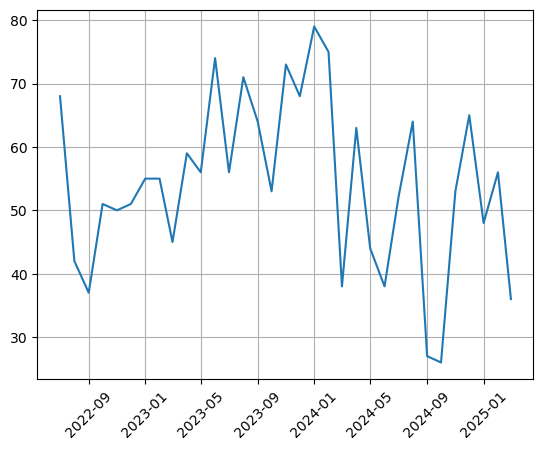

In [234]:
plt.plot(gb['playlist_date'], gb['n_genres'])
plt.grid()
plt.xticks(rotation = 45)
plt.show()

<Axes: >

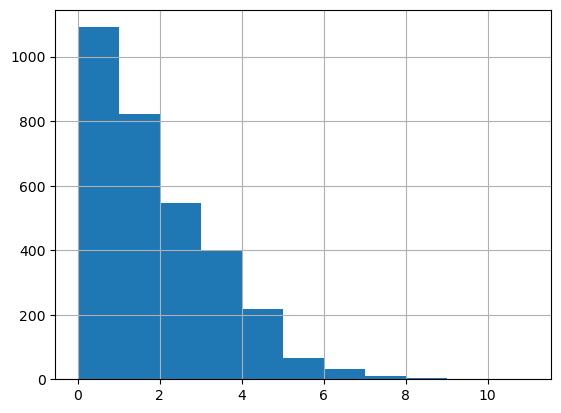

In [213]:
df_tracks['artist_genres'].apply(lambda x: len(x)).hist(bins = 11)

In [153]:
df_tracks.groupby(by='track_artist').agg({'playlist_name':'count'}).sort_values('playlist_name',ascending=False)  

,playlist_name
track_artist,
The Beatles,102
Vulfpeck,86
Kanye West,73
Masayoshi Takanaka,54
BADBADNOTGOOD,53
...,...
Light Club,1
Life on Planets,1
Liam Bailey,1


In [163]:
df_tracks[df_tracks['track_name'] == 'Love Is a Beautiful Thing']

,playlist_name,track_index,added_date,track_name,track_artist,track_artist_index,track_album,track_release_date,track_release_date_precision,track_popularity,track_duration_ms,track_external_ids,track_spotify_id,playlist_date,isrc_country
434,09-24,19,2024-09-25 10:40:04+00:00,Love Is a Beautiful Thing,Vulfpeck,1,Hill Climber,2018-12-07,day,41,233314,{'isrc': 'TCADW1815720'},59qmUODXmHXiWwvG8WdzEW,2024-09-01,TC
435,09-24,19,2024-09-25 10:40:04+00:00,Love Is a Beautiful Thing,Theo Katzman,2,Hill Climber,2018-12-07,day,41,233314,{'isrc': 'TCADW1815720'},59qmUODXmHXiWwvG8WdzEW,2024-09-01,TC
436,09-24,19,2024-09-25 10:40:04+00:00,Love Is a Beautiful Thing,Monica Martin,3,Hill Climber,2018-12-07,day,41,233314,{'isrc': 'TCADW1815720'},59qmUODXmHXiWwvG8WdzEW,2024-09-01,TC
1966,05 23,26,2023-05-10 08:32:40+00:00,Love Is a Beautiful Thing,Vulfpeck,1,Hill Climber,2018-12-07,day,41,233314,{'isrc': 'TCADW1815720'},59qmUODXmHXiWwvG8WdzEW,2023-05-01,TC
1967,05 23,26,2023-05-10 08:32:40+00:00,Love Is a Beautiful Thing,Theo Katzman,2,Hill Climber,2018-12-07,day,41,233314,{'isrc': 'TCADW1815720'},59qmUODXmHXiWwvG8WdzEW,2023-05-01,TC
1968,05 23,26,2023-05-10 08:32:40+00:00,Love Is a Beautiful Thing,Monica Martin,3,Hill Climber,2018-12-07,day,41,233314,{'isrc': 'TCADW1815720'},59qmUODXmHXiWwvG8WdzEW,2023-05-01,TC
3854,december 2021,16,2021-12-02 16:09:55+00:00,Love Is a Beautiful Thing,Vulfpeck,1,Hill Climber,2018-12-07,day,41,233314,{'isrc': 'TCADW1815720'},59qmUODXmHXiWwvG8WdzEW,2021-12-01,TC
3855,december 2021,16,2021-12-02 16:09:55+00:00,Love Is a Beautiful Thing,Theo Katzman,2,Hill Climber,2018-12-07,day,41,233314,{'isrc': 'TCADW1815720'},59qmUODXmHXiWwvG8WdzEW,2021-12-01,TC
3856,december 2021,16,2021-12-02 16:09:55+00:00,Love Is a Beautiful Thing,Monica Martin,3,Hill Climber,2018-12-07,day,41,233314,{'isrc': 'TCADW1815720'},59qmUODXmHXiWwvG8WdzEW,2021-12-01,TC
3896,december 2021,46,2021-12-07 21:48:54+00:00,Love Is a Beautiful Thing,Theo Katzman,1,Heartbreak Hits,2017-01-06,day,37,210251,{'isrc': 'TCACU1609265'},6NzE6TTlRMXonm5YEMVlVc,2021-12-01,TC


In [171]:
gb = df_tracks.groupby(by=['track_name','track_album']).agg({'playlist_name':'count','track_artist_index':'max'})
gb['res'] = (gb['playlist_name']/gb['track_artist_index']).astype(int)

gb.sort_values('res',ascending=False)[['res']].reset_index().groupby('track_name').agg({'res':'sum'}).sort_values('res', ascending=False)

,res
track_name,
Three Man Weave,8
Boogie Man,7
Heatwave,7
Animal Spirits,6
Tee Time,6
...,...
How to Love (Intro),1
Huit octobre 1971,1
Hunnybee,1


In [118]:
df_tracks.groupby(by = ['playlist_name','track_name']).agg({'track_artist_index':'count'}).reset_index().sort_values(by=['playlist_name','track_artist_index'], ascending=False)

,playlist_name,track_name,track_artist_index
4587,september 2021,Drive Slow,3
4588,september 2021,Everything I Am,2
4591,september 2021,I Ain't Done Wrong,2
4594,september 2021,I'm Not Talking,2
4598,september 2021,Maze of Sounds,2
...,...,...,...
92,01 23,Where Can I Go?,1
94,01 23,Who Knows,1
95,01 23,Wouldn't It Be Nice - Mono,1
96,01 23,You're so Fine,1


In [174]:
df_tracks['track_album'].drop_duplicates().to_frame()

,track_album
0,Dire Straits
6,Communiqué
10,Moon - EP
12,Clarity of Cal
13,Fugue State
...,...
6168,Doris
6192,Hell Can Wait
6193,Prima Donna
6197,Below the Heavens


In [175]:
df_tracks['track_artist'].drop_duplicates().to_frame()

,track_artist
0,Dire Straits
10,M|O|O|N
12,Vulfpeck
16,Tom Misch
18,Niko B
...,...
6161,Austin Feinstein
6188,Chester P
6191,Rude Kid
6198,Exile
